In [2]:
import pandas

replays = pandas.read_csv('HOTSLogs Data Export Current/Replays.csv')

In [31]:
print(replays.columns)

Index(['ReplayID',
       'GameMode(3=Quick Match 4=Hero League 5=Team League 6=Unranked Draft 7=Brawl 8=Storm League)',
       'MapID', 'Replay Length', 'Timestamp (UTC)'],
      dtype='object')


In [24]:
is_interesting_game = replays['GameMode(3=Quick Match 4=Hero League 5=Team League 6=Unranked Draft 7=Brawl 8=Storm League)'] == 5

In [28]:
interesting_replays = replays[is_interesting_game]
interesting_replays.head(3)

,ReplayID,GameMode(3=Quick Match 4=Hero League 5=Team League 6=Unranked Draft 7=Brawl 8=Storm League),MapID,Replay Length,Timestamp (UTC)
441046,165853688,5,1009,00:14:00,2/16/2019 12:57:22 AM
441047,165415972,5,1003,00:18:22,2/16/2019 12:58:05 AM
441048,165415971,5,1004,00:16:33,2/16/2019 12:58:06 AM


In [30]:
print(len(interesting_replays))

161788


In [32]:
details = pandas.read_csv('HOTSLogs Data Export Current/ReplayCharacters.csv')

In [33]:
details.head(3)

,ReplayID,Is Auto Select,HeroID,Hero Level,Is Winner,MMR Before,In Game Level,Takedowns,Killing Blows,Assists,Deaths,Highest Kill Streak,Hero Damage,Siege Damage,Healing,Self Healing,Damage Taken,Experience Contribution,Time Spent Dead,Merc Camp Captures
0,165418633,0,29,20,1,2240.0,21,10,6,4,2,6,36450,107372,NaN,0,25561.0,15421,00:01:20,4
1,165418633,0,76,3,0,2611.0,18,4,1,3,4,2,28852,55391,12594.0,12510,61556.0,7905,00:02:56,0
2,165418633,0,31,20,1,2380.0,21,9,3,6,3,5,35131,34866,NaN,15384,44616.0,6910,00:02:13,4


In [38]:
interesting_replay_ids = set(interesting_replays['ReplayID'])

In [43]:
class RelayDetail:
    def __init__(self):
        self.win_team = []
        self.lose_team = []
        
id2details = {}
for index, row in details.iterrows():
    replay_id = row['ReplayID']
    hero = row['HeroID']
    is_winner = row['Is Winner']
    if replay_id in interesting_replay_ids:
        if replay_id not in id2details:
            id2details[replay_id] = RelayDetail()
        if is_winner == 1:
            id2details[replay_id].win_team.append(hero)
        else:
            id2details[replay_id].lose_team.append(hero)
print(len(interesting_replay_ids), len(id2details))

161788 161788


In [59]:
from collections import defaultdict

class ComboInfo:
    def __init__(self):
        self.freq = 0
        self.values = []
        
combo2info = {}

def add_combo(key, value):
    
    global combo2info
    if key not in combo2info:
        combo2info[key] = ComboInfo()
    combo2info[key].freq += 1
    combo2info[key].values.append(value)

    
def get_subset(team, mask):
    
    ret = []
    for i in range(5):
        if (mask >> i & 1) == 1:
            ret.append(str(team[i]))
    return ','.join(ret)

    
for replay_id, game in id2details.items():
    game.win_team.sort()
    game.lose_team.sort()
    for mask in range(1, 1 << 5):
        add_combo(get_subset(game.win_team, mask), 1)
        add_combo(get_subset(game.lose_team, mask), -1)

[('2,24', 14.067244028785062, -0.0019007364459020246), ('2,12', 13.519333731463524, 0.014722187510541948), ('14,24', 11.190240269016325, -0.17407087626095813), ('2,14', 10.802312353739383, -0.012553685162394045), ('2,72', 10.690728015125357, 0.046435289001205166), ('2,25', 9.541925833802996, 0.010570256216483885), ('2,61', 9.275942884730185, 0.0005691211661124939), ('2,59', 9.180371421313628, -0.32662923733046484), ('12,24', 8.918922026489229, -0.1273473797117349), ('2,9', 8.910833305956961, 0.03997829726852673)]
[('20,85', -8.773130551906943, -0.45299713364500904), ('44,45', -8.939345689023526, 4.935283962700868), ('48,85', -8.974638742186396, 0.03699360338177045), ('48,70', -9.034416721617198, 0.02750989141810043), ('20,75', -9.371229415319078, 0.06543743710178329), ('48,66', -10.11080327724043, -0.2722054423832485), ('48,75', -10.861456941785619, -0.3569519909914089), ('7,48', -11.448668810703964, 0.0971244464984757), ('20,66', -12.125390337670733, 0.04829761222681868), ('20,48', -1

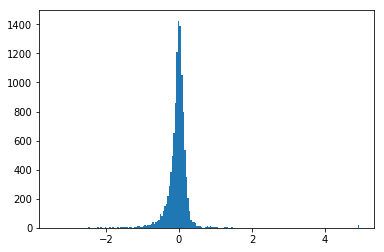

In [83]:
from scipy import stats
from math import *
from matplotlib import pyplot as plt

order = []
pmis = []
for combo, info in combo2info.items():
    if info.freq < 100:
        continue
    heros = combo.split(',')
    if len(heros) == 1:
        continue
    
    pmi = -1e100
    for mask in range(1, (1 << len(heros)) - 1):
        part1 = []
        part2 = []
        for i in range(len(heros)):
            if (mask >> i & 1) == 1:
                part1.append(heros[i])
            else:
                part2.append(heros[i])
        p1 = combo2info[','.join(part1)].freq / len(id2details)
        p2 = combo2info[','.join(part2)].freq / len(id2details)
        p12 = info.freq / len(id2details)
        pmi = max(pmi, log(p12 / (p1 * p2 * 0.5)))
        
    pmis.append(pmi)

    mean = sum(info.values) / info.freq
    stderror = stats.sem(info.values)
    t_stat = mean / stderror
    order.append((combo, t_stat, pmi))
        
order.sort(key = lambda x : -x[1])
print(order[:10])
print(order[-10:])

plt.hist(pmis, bins = 200)
plt.show()

In [61]:
id2name = {}
for line in open('HOTSLogs Data Export Current/HeroIDAndMapID.csv'):
    parts = line.split(',')
    id2name[parts[0]] = parts[1]

In [114]:
print('t-stat    PMI    Rate    Hero Combination')
for combo, t_stat, pmi in order:
    heros = combo.split(',')
    if abs(t_stat) > 3 and pmi >= 0.3:
        ret = ''
        ret += '{message: <10}'.format(message = '%.2f' % t_stat)
        ret += '{message: <7}'.format(message = '%.2f' % pmi)
        ret += '{message: <8}'.format(message = '%.2f' % (sum(combo2info[combo].values) / combo2info[combo].freq))
        for hero in heros:
            ret += '{message: <16}'.format(message=id2name[hero])
        print(ret)

t-stat    PMI    Rate    Hero Combination
6.77      0.34   0.14    Malthael        Ana             
5.28      0.33   0.38    Anub'arak       Leoric          Tyrande         
4.77      0.48   0.26    Anub'arak       Malthael        Ana             
4.73      0.37   0.28    Arthas          Alarak          Ana             
4.63      0.37   0.16    Illidan         Uther           
4.55      0.36   0.35    Thrall          Alarak          Ana             
4.50      0.46   0.27    Azmodan         Raynor          Lt. Morales     
4.46      1.23   0.30    Abathur         Illidan         Jaina           
4.36      1.92   0.26    Abathur         Illidan         Uther           
4.35      1.33   0.34    Abathur         Illidan         Orphea          
3.94      0.44   0.26    Anub'arak       Valla           Lt. Morales     
3.93      1.46   0.08    Abathur         Illidan         
3.86      0.43   0.22    Arthas          Raynor          Lt. Morales     
3.70      0.79   0.24    Anub'arak       Val